In [1]:
import jax
import jax.numpy as jnp

### Force CPU usage

Making the algorithm work on GPU is left for future work.

In [2]:
%env CUDA_VISIBLE_DEVICES=""

env: CUDA_VISIBLE_DEVICES=""


Jax runs in `float32` by default, which is not enough precision for our purposes. We force it to `float64` instead.

In [3]:
jax.config.update("jax_enable_x64", True)

In [4]:
from variables import VariablePartition
from function_basis import HatFunctions
from kernels import GaussianKernel
from constraints import NoConstraints
from additive_gp import ConstrainedAdditiveGP

## Example in 2D

We rely on the illustration p2 of the paper [1].

[1] López-Lopera, A., Bachoc, F. and Roustant, O., 2022.
    *High-dimensional additive Gaussian processes under monotonicity constraints.*
    Advances in Neural Information Processing Systems, 35, pp.8041-8053.

In [5]:
x_train = jnp.array([[0.5, 0.], [0.5, 0.5], [0.5, 1.], [0., 0.5], [1., 0.5]])

def y_ground_truth(x):
  return 4 * (x[:,0] - 0.5)**2 + 2 * x[:,1]

y_train = y_ground_truth(x_train)
y_train

2023-08-30 16:06:55.980302: E external/xla/xla/stream_executor/cuda/cuda_driver.cc:268] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


Array([0., 1., 2., 2., 2.], dtype=float64)

In [6]:
# discretize [0, 1]^2 with 50 points in each direction
knots = jnp.linspace(0, 1, 50)
x1, x2 = jnp.meshgrid(knots, knots)
x_test = jnp.stack([x1.flatten(), x2.flatten()], axis=1)
y_test = y_ground_truth(x_test)

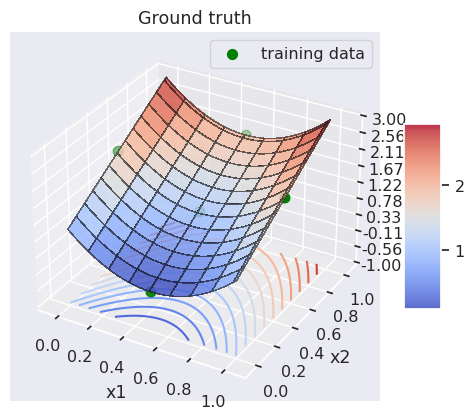

In [7]:
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator
import seaborn as sns
import numpy as np

def plot_surface_3d(x1, x2, y, x_train, y_train, title=""):
  sns.set_style("whitegrid")
  sns.set_context("paper")
  sns.set(font_scale=1.05)
  fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
  edgecolor = (0.1, 0.1, 0.1, 0.6)
  surf = ax.plot_surface(x1, x2, y, cmap=cm.coolwarm,
                        linewidth=0.3, antialiased=False,
                        edgecolor=edgecolor,
                        rstride=4, cstride=6,
                        alpha=0.8)
  ax.contour(x1, x2, y, zdir='z', offset=-1, cmap='coolwarm', levels=15)
  ax.set(xlim=(-0.1, 1.1), ylim=(-0.1, 1.1), zlim=(-1, 3),
         xlabel='x1', ylabel='x2', zlabel='y')
  ax.zaxis.set_major_locator(LinearLocator(10))
  ax.zaxis.set_major_formatter('{x:.02f}')
  ax.scatter(x_train[:, 0], x_train[:, 1], y_train, c='green', s=50, label='training data')
  ax.legend()
  fig.colorbar(surf, shrink=0.5, aspect=5)
  ax.set_title(title)

plot_surface_3d(x1, x2, y_test.reshape(x1.shape), x_train, y_train, "Ground truth")

First, we rely on conventional Gaussian process regression, so we assume joint effects (no additive structure),
and we do not impose monotonicity or convexity constraints.

### Step by step creation of toy example.

1) We start with a discretization of the domain.

In [8]:
from variables import isotropic_block  # helper function to create a block of variables

block = isotropic_block(names='xy', indices=[0, 1], domain=(0, 1), num_ticks=5)  # hypercube in [0, 1]^2 with 5 subdivisions in each direction.

2) We build a trivial partition that consists of a single block.

In [9]:
partition = VariablePartition([block])

3) For the basis of functions, we rely on Hat functions thanks to their simplicity and their ability to be combined to form more complex functions.

In [10]:
basis = HatFunctions(max_value=1.0)

4. We use the so-called Gaussian kernel, or RBF (that stands for "Radial Basis Functions") defined as:
$$k(x,y)=\exp{\left(-\frac{\|x-y\|^2_2}{l^2}\right)}$$
Note that this multivariate kernel is indeed a product of univariate kernels:
$$k(x,y)=\prod_{i=1}^d k(x_i,y_i)$$
where $k(x_i,y_i)=\exp{\left(-\frac{(x_i-y_i)^2}{l^2}\right)}$ is the univariate kernel for the $i$-th dimension.  
  
The value of $l$ is chosen automatically based on an heuristic, but it can be rescaled with the `length_scale` parameter. This improves the numerical stability of the algorithm.

In [11]:
kernel = GaussianKernel(length_scale=1.)

5. We consider a very simple Gaussian process without any constraints on the learned functions.

In [12]:
constraints = NoConstraints()
# constraints = [NoConstraints()] would also work.
# constraints = None would also work.

6. We are now ready to go! The model is fully defined.

In [13]:
monoblock_gp = ConstrainedAdditiveGP(partition, basis, kernel, constraints)

We fit the model:

In [14]:
additive_fun = monoblock_gp.fit(x_train, y_train)

We used the additive GP to predict labels on new entries.

In [15]:
structured_pred = additive_fun.predict(x_train)
structured_pred

StructuredPrediction(y_pred=Array([1.79572118e-04, 1.00439085e+00, 1.99786921e+00, 1.99652799e+00,
       1.99652799e+00], dtype=float64), y_pred_per_block=[Array([1.79572118e-04, 1.00439085e+00, 1.99786921e+00, 1.99652799e+00,
       1.99652799e+00], dtype=float64)])

We are interested on the final prediction to compute the metrics. The `y_pred_per_block` fields is here for debugging purpose.

In [16]:
y_pred = structured_pred.y_pred

Let's compute some metrics on the train set and the test set!

In [17]:
from utils import regression_report
regression_report(y_train, y_pred)  # train set

Mean squared error: 0.0000
Mean absolute error: 0.0027
Explained variance score: 99.9986%


,x[0],x[1],x[2],x[3],x[4]
absolute_error,0.00018,0.004391,0.002131,0.003472,0.003472


In [18]:
y_pred = additive_fun.predict(x_test).y_pred
_ = regression_report(y_test, y_pred)  # test set

Mean squared error: 0.0261
Mean absolute error: 0.1032
Explained variance score: 94.1145%


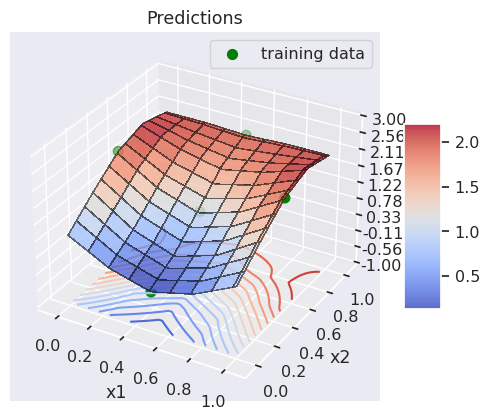

In [19]:
plot_surface_3d(x1, x2, y_pred.reshape(x1.shape), x_train, y_train, "Predictions")

### Additive structure

We now assume there exists an additive structure, such that:
$$Y(x_1,x_2) = Y_1(x_1) + Y(x_2).$$

We reflect this by modifying appropriately the partition variable so that it contains two disjoint blocks of one variable each.

In [20]:
from variables import block_1D

block_1 = block_1D(name='x1', index=0, domain=(0., 1.), num_ticks=10)
block_2 = block_1D(name='x2', index=1, domain=(0., 1.), num_ticks=10)
partition = VariablePartition([block_1, block_2])

In [21]:
multiblock_gp = ConstrainedAdditiveGP(partition, basis, kernel, constraints)
additive_fun = multiblock_gp.fit(x_train, y_train)
y_pred = additive_fun.predict(x_train).y_pred
regression_report(y_train, y_pred)  # train set

Mean squared error: 0.0000
Mean absolute error: 0.0014
Explained variance score: 99.9997%


,x[0],x[1],x[2],x[3],x[4]
absolute_error,0.000267,0.002167,0.001746,0.001311,0.001311


In [22]:
structured_pred = additive_fun.predict(x_test)
y_pred = structured_pred.y_pred
_ = regression_report(y_test, y_pred)  # test set

Mean squared error: 0.0411
Mean absolute error: 0.1643
Explained variance score: 95.0178%


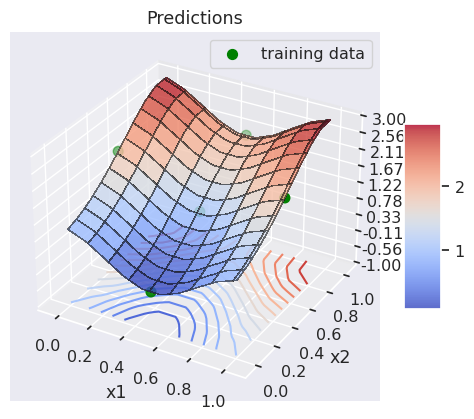

In [23]:
plot_surface_3d(x1, x2, y_pred.reshape(x1.shape), x_train, y_train, "Predictions")

### Simple constraint

The next step on our journey is to incorporate constraints. Let's see what happens with a bounded constraint.  
This constraint has the advantage to be really simple. We chose on purpose values that are inappropriate to induce a failure of the algorithm.

In [24]:
block_1 = block_1D(name='x1', index=0, domain=(0., 1.), num_ticks=5)
block_2 = block_1D(name='x2', index=1, domain=(0., 1.), num_ticks=5)
partition = VariablePartition([block_1, block_2])

We impose the constraint $Y_1(x_1)\in [0.5, 1.1]$. Why ? Because we can, that's why.

In [25]:
from constraints import BoundedConstraints, NoConstraints

bounded_constraint = BoundedConstraints(min_value=0.5, max_value=1.1)
# bounded constraint on block_1 only, no constraints on block_2.
constraints = [bounded_constraint, NoConstraints()]  

We re-used the same partition as before.

In [26]:
bounded_gp = ConstrainedAdditiveGP(partition, basis, kernel, constraints)
additive_fun = bounded_gp.fit(x_train, y_train)
y_pred = additive_fun.predict(x_train).y_pred
regression_report(y_train, y_pred)  # train set

Mean squared error: 0.0213
Mean absolute error: 0.1071
Explained variance score: 96.6666%


,x[0],x[1],x[2],x[3],x[4]
absolute_error,0.000726,0.266483,0.001309,0.133517,0.133517


In [27]:
structured_pred = additive_fun.predict(x_test)
y_pred = structured_pred.y_pred
_ = regression_report(y_test, y_pred)  # test set

Mean squared error: 0.0481
Mean absolute error: 0.1797
Explained variance score: 91.4935%


As expected, the MSE is worse. This is due to the fact that the constraint is too restrictive. We can see the constraints taking effects by looking at the `y_pred_per_block` field of `structured_pred` variable.

In [28]:
structured_pred.y_pred_per_block[0]

Array([1.10000002, 1.07311695, 1.04623387, ..., 1.04623382, 1.07311692,
       1.10000002], dtype=float64)

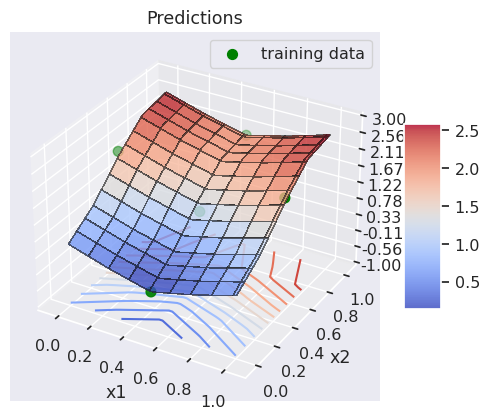

In [29]:
plot_surface_3d(x1, x2, y_pred.reshape(x1.shape), x_train, y_train, "Predictions")

### Monotonicity constraint

We level up our game by imposing a monotonicity constraint on x2. This is more compliant with the ground truth.

In [30]:
from constraints import MonotoneConstraints

monotonicity = MonotoneConstraints('increasing')
constraints = [NoConstraints(), monotonicity]  

You know what follows!

In [31]:
block_1 = block_1D(name='x1', index=0, domain=(0., 1.), num_ticks=5)
block_2 = block_1D(name='x2', index=1, domain=(0., 1.), num_ticks=5)
partition = VariablePartition([block_1, block_2])
monotone_gp = ConstrainedAdditiveGP(partition, basis, kernel, constraints)
additive_fun = monotone_gp.fit(x_train, y_train)
y_pred = additive_fun.predict(x_train).y_pred
regression_report(y_train, y_pred)  # train set

Mean squared error: 0.0000
Mean absolute error: 0.0015
Explained variance score: 99.9996%


,x[0],x[1],x[2],x[3],x[4]
absolute_error,0.000253,0.002475,0.001782,0.001411,0.001411


In [32]:
structured_pred = additive_fun.predict(x_test)
y_pred = structured_pred.y_pred
_ = regression_report(y_test, y_pred)  # test set

Mean squared error: 0.0345
Mean absolute error: 0.1531
Explained variance score: 96.7588%


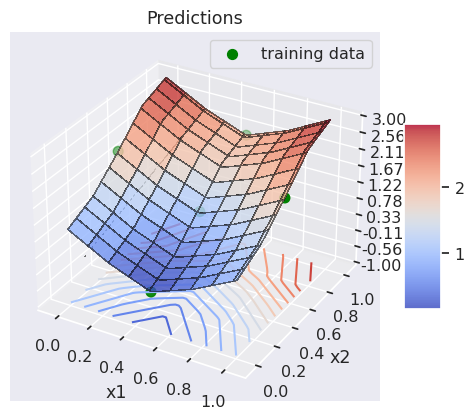

In [33]:
plot_surface_3d(x1, x2, y_pred.reshape(x1.shape), x_train, y_train, "Predictions")

We obtain our best MSE so far. The monotonicity constraint is respected, as we can see on the `y_pred_per_block` field of `structured_pred` variable.

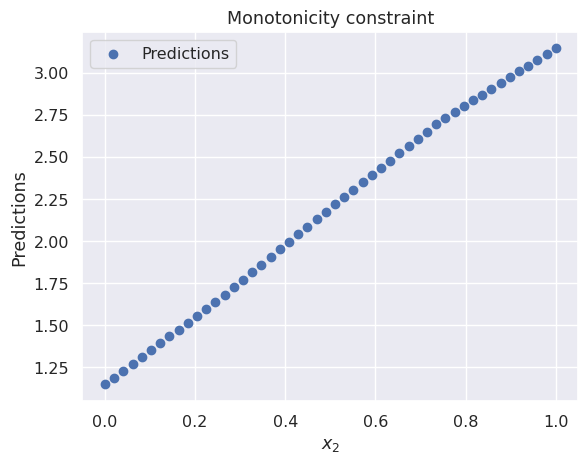

In [40]:
pred_Y2 = structured_pred.y_pred_per_block[1]
pred_Y2 = pred_Y2[::50]  # take every 50th value of the flat vector of length 2500 = 50x50
plt.scatter(jnp.linspace(0, 1, len(pred_Y2)), pred_Y2, label='Predictions')
plt.xlabel('$x_2$')
plt.ylabel('Predictions')
plt.title('Monotonicity constraint')
plt.legend()

### Packing-up everything with Convexity constraint  
  
We introduce the convexity constraint on $Y_1(x_1)$.  

In [36]:
from constraints import CurvatureConstraints
from solver import ConstraintsSolver

convex_x1 = CurvatureConstraints('convex')
increasing_x2 = MonotoneConstraints('increasing')
constraints = [convex_x1, increasing_x2]

block_1 = block_1D(name='x1', index=0, domain=(0., 1.), num_ticks=5)
block_2 = block_1D(name='x2', index=1, domain=(0., 1.), num_ticks=5)
partition = VariablePartition([block_1, block_2])

basis = HatFunctions(max_value=1.0)
kernel = GaussianKernel(length_scale=3.0)  # this value works well here after trial and errors.  
solver = ConstraintsSolver()  # default solver, showed here for completeness.

constrained_gp = ConstrainedAdditiveGP(partition, basis, kernel, constraints, solver=solver)

In [37]:
additive_fun = constrained_gp.fit(x_train, y_train)
y_pred = additive_fun.predict(x_train).y_pred
regression_report(y_train, y_pred)  # train set

Mean squared error: 0.0006
Mean absolute error: 0.0193
Explained variance score: 99.9037%


,x[0],x[1],x[2],x[3],x[4]
absolute_error,0.001748,0.046794,0.007306,0.020445,0.020445


In [38]:
structured_pred = additive_fun.predict(x_test)
y_pred = structured_pred.y_pred
_ = regression_report(y_test, y_pred)  # test set

Mean squared error: 0.0043
Mean absolute error: 0.0570
Explained variance score: 99.6127%


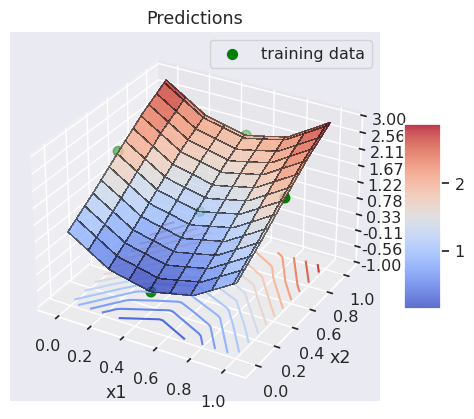

In [39]:
plot_surface_3d(x1, x2, y_pred.reshape(x1.shape), x_train, y_train, "Predictions")

### What's next ?

For now the hyper-parameters of the kernel (variance and length scale) are fixed.  
We could optimize them with a cross-validation procedure, or by maximizing the marginal likelihood, following the conventions of Gaussian process regression. However, estimating the marginal likelihood is not trivial in the case of additive Gaussian processes subject to constraints.